<a href="https://colab.research.google.com/github/Daniellien2018/Project_6_Plants_Seedling_Classificaiton/blob/main/Daniel_Lien_Plant_Seedling_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
import os
import cv2 #openCV
import math #for rand seed
import random

#data manipulationg
import numpy as np
import pandas as pd

#plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

#tensorflow for model building
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator#image processing
from tensorflow.keras.models import Sequential#building sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization #layer building
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import backend

#sklearn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#google/keras to display images
from google.colab.patches import cv2_imshow
from keras.callbacks import ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#create paths to both datasets
images_path='/content/drive/My Drive/UT Austin AIML/Datasets/images.npy'
labels_path='/content/drive/My Drive/UT Austin AIML/Datasets/Labels.csv'

In [ ]:
images = np.load(images_path)

In [ ]:
labels= pd.read_csv(labels_path)

## Data Overview

### Understand the shape of the dataset

In [ ]:
#check shape of image dataset
images.shape

(4750, 128, 128, 3)

In [ ]:
#check shape of labels dataset
labels.shape

(4750, 1)

In [ ]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

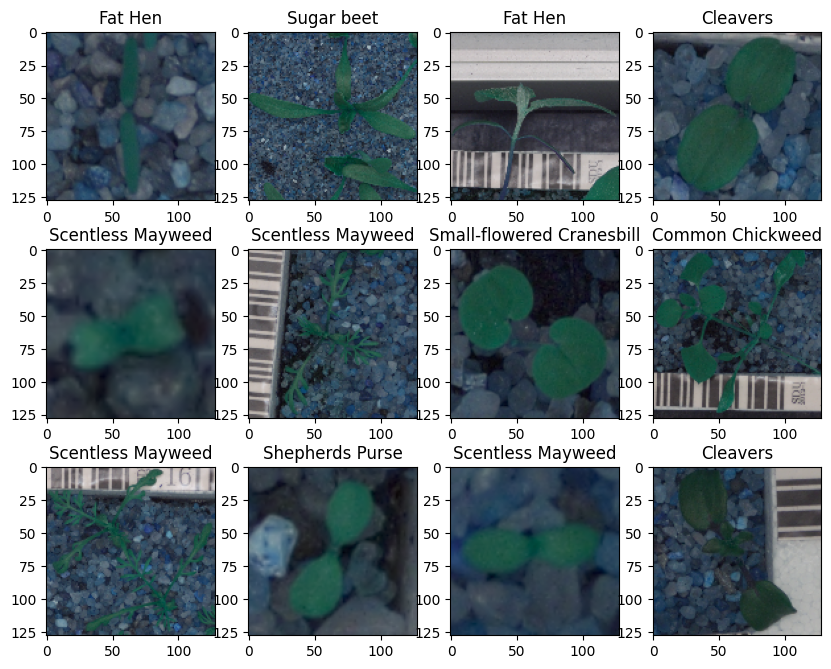

In [ ]:
plot_images(images, labels)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

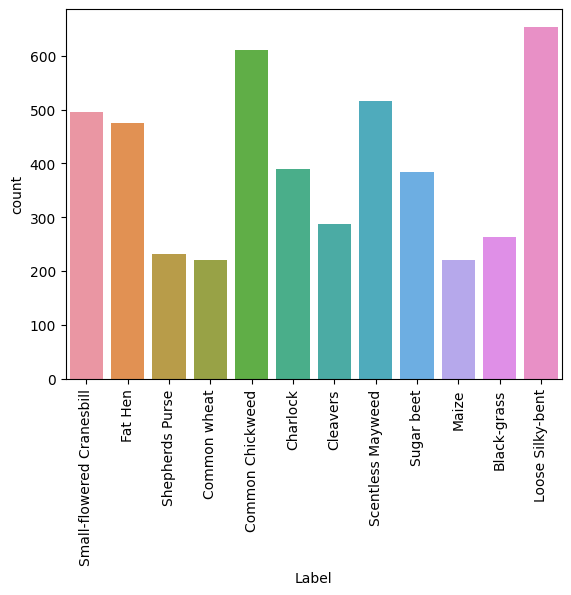

In [ ]:
#checking distribution of target variable (labels)
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:
#images is a dataset, iterate, and convert BGR to RGD using cvt color in OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
#iterate images and resize using cv2.resize
# syntax: cv2.resize(source, dsize, dest, fx,fy,interpolation)

images_decreased=[]
dimensions = (64, 64)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

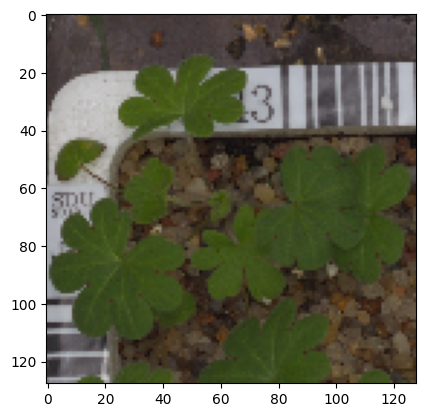

In [ ]:
#check image before resize
plt.imshow(images[3])

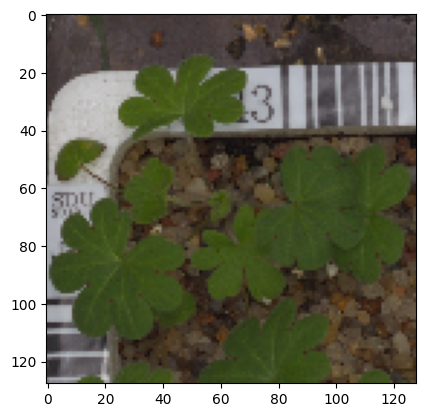

In [ ]:
#compare to image after
plt.imshow(images[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
#split into 80/10/10
X_temp,X_test, y_temp, y_test = train_test_split(np.array(images_decreased),
                                                 labels,
                                                 test_size=0.1,
                                                 random_state=42,
                                                 stratify=labels)

#take 90 and split into 90/10 again
X_train,X_val, y_train, y_val = train_test_split(X_temp,
                                                 y_temp,
                                                 test_size=0.1,
                                                 random_state=42,
                                                 stratify=y_temp)

In [ ]:
# check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [ ]:
#convert label names to one-hot vector using label binarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

In [ ]:
#check shapes of encoded data, should match
print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)

(3847, 12)
(428, 12)
(475, 12)


### Data Normalization

In [ ]:
#normalize the images pizels of train, test and validation
#scale the data by dividing all pixel values by 255 to standadize values
#this will help with model speed
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## Model Building

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
# set random seeds for rng
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
model1 = Sequential()

#add first conv layer with 128, max pooling to reduce size of output
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

#add second layer with similar characteristics
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

#add third layer with similar characteristics
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten outoput of the conv layer after pooling, ready to connect dense layers
model1.add(Flatten())

#add fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

#add fully connected layer with 12 neurons
#softmax because of multi-class classfication
model1.add(Dense(12, activation='softmax'))


opt=Adam()
# Compile the model using categorical crossentropy for classification problems
model1.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [ ]:
# fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 110s - loss: 2.4625 - accuracy: 0.1175 - val_loss: 2.4474 - val_accuracy: 0.1285 - 110s/epoch - 910ms/step
Epoch 2/30
121/121 - 77s - loss: 2.4453 - accuracy: 0.1217 - val_loss: 2.4325 - val_accuracy: 0.0935 - 77s/epoch - 638ms/step
Epoch 3/30
121/121 - 78s - loss: 2.4287 - accuracy: 0.1126 - val_loss: 2.4432 - val_accuracy: 0.1752 - 78s/epoch - 648ms/step
Epoch 4/30
121/121 - 76s - loss: 2.3890 - accuracy: 0.1536 - val_loss: 2.1488 - val_accuracy: 0.2921 - 76s/epoch - 631ms/step
Epoch 5/30
121/121 - 102s - loss: 2.0884 - accuracy: 0.2898 - val_loss: 1.8945 - val_accuracy: 0.3645 - 102s/epoch - 841ms/step
Epoch 6/30
121/121 - 84s - loss: 1.9579 - accuracy: 0.3008 - val_loss: 1.8276 - val_accuracy: 0.3855 - 84s/epoch - 695ms/step
Epoch 7/30
121/121 - 73s - loss: 1.8821 - accuracy: 0.3192 - val_loss: 1.6015 - val_accuracy: 0.4136 - 73s/epoch - 607ms/step
Epoch 8/30
121/121 - 74s - loss: 1.8288 - accuracy: 0.3366 - val_loss: 1.6689 - val_accuracy: 0.4486 - 74s/epoch -

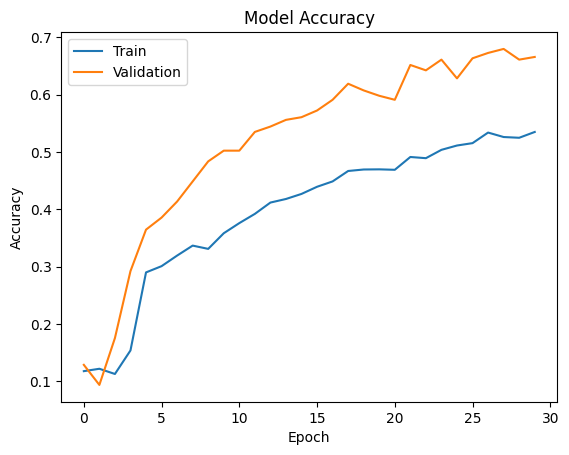

In [ ]:
#plot
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#evaluate the model on test data
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 4s - loss: 1.0838 - accuracy: 0.6421 - 4s/epoch - 239ms/step


In [ ]:
#plotting confusion matrix, output is the probabilities for each category, use X_val
y_pred=model1.predict(X_test_normalized)

15/15 [==============================] - 3s 230ms/step


In [ ]:
#check shape again
print(y_test_encoded.shape)
print(y_pred.shape)

(475, 12)
(475, 12)


(475, 12)
(475, 12)


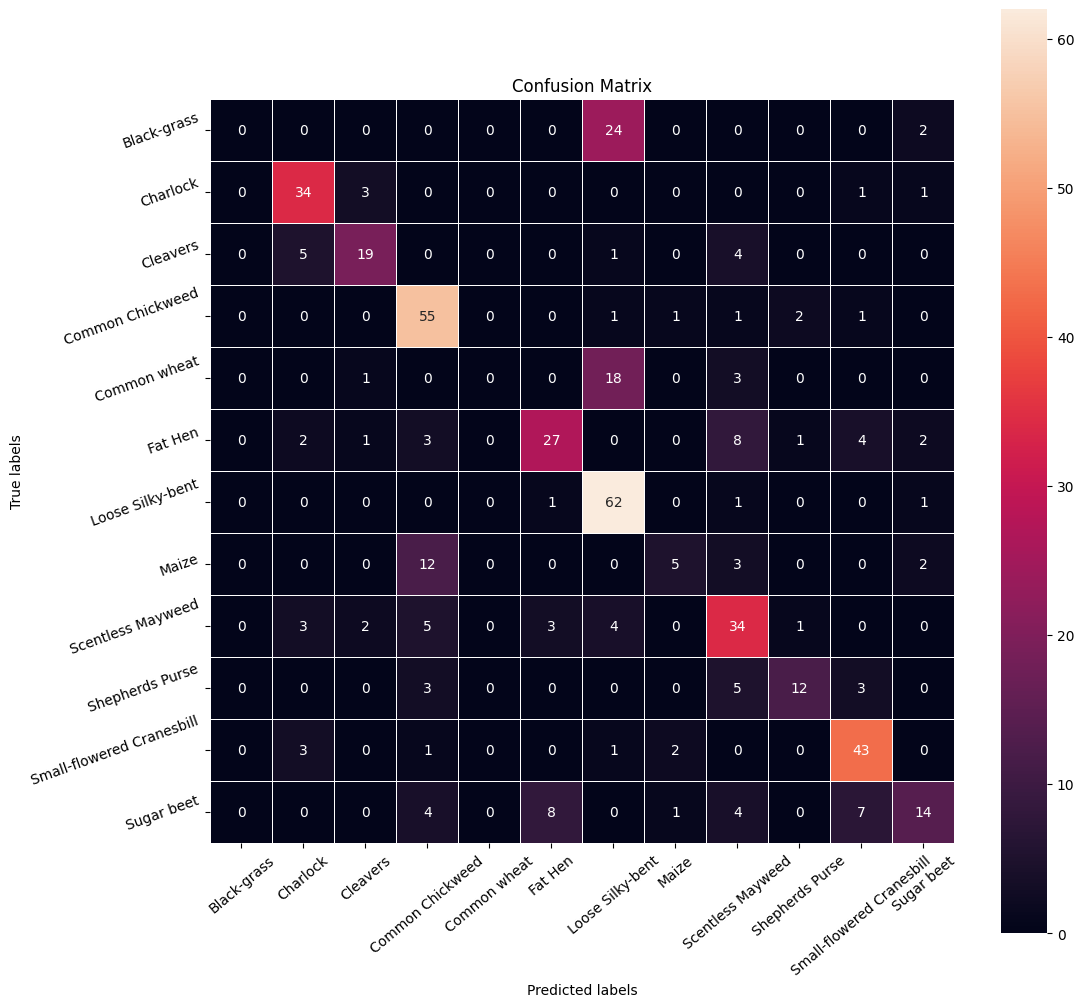

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [ ]:
#plotting classification report
from sklearn import metrics
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.72      0.87      0.79        39
           2       0.73      0.66      0.69        29
           3       0.66      0.90      0.76        61
           4       0.00      0.00      0.00        22
           5       0.69      0.56      0.62        48
           6       0.56      0.95      0.70        65
           7       0.56      0.23      0.32        22
           8       0.54      0.65      0.59        52
           9       0.75      0.52      0.62        23
          10       0.73      0.86      0.79        50
          11       0.64      0.37      0.47        38

    accuracy                           0.64       475
   macro avg       0.55      0.55      0.53       475
weighted avg       0.58      0.64      0.59       475



## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
#monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [ ]:
# Intializing a sequential model
model2 = Sequential()

# add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# add the output layer with 12 neurons and softmax
model2.add(Dense(12, activation='softmax'))

# Complete the code to initialize Adam Optimimzer
opt=Adam()
# Complete the code to Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [ ]:
#fitting model on train data
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 40s 625ms/step - loss: 2.1267 - accuracy: 0.2530 - val_loss: 2.3922 - val_accuracy: 0.1986 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 36s 598ms/step - loss: 1.6694 - accuracy: 0.4198 - val_loss: 2.3079 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 36s 596ms/step - loss: 1.4790 - accuracy: 0.4732 - val_loss: 2.2384 - val_accuracy: 0.3668 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 39s 652ms/step - loss: 1.3953 - accuracy: 0.5028 - val_loss: 2.1230 - val_accuracy: 0.5164 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 36s 596ms/step - loss: 1.2650 - accuracy: 0.5456 - val_loss: 1.8393 - val_accuracy: 0.4252 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 38s 628ms/step - loss: 1.1948 - accuracy: 0.5697 - val_loss: 1.6660 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 37s 620ms/st

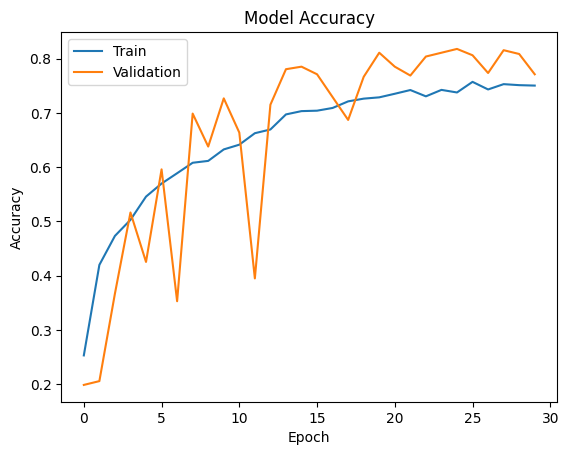

In [ ]:
#model evaluation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#evaluate the model on test data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 3s - loss: 0.8453 - accuracy: 0.7495 - 3s/epoch - 188ms/step


In [ ]:
# obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 3s 156ms/step


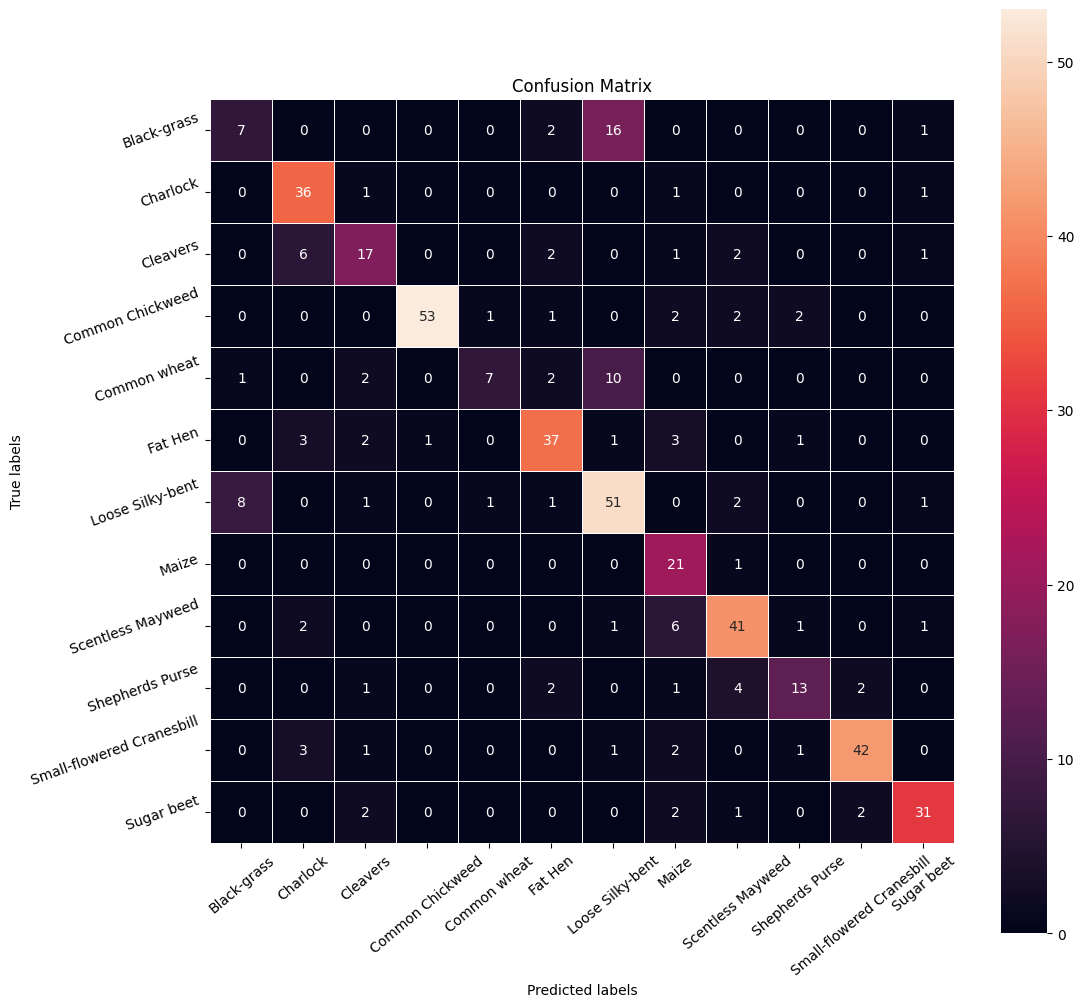

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [ ]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)
print(cr)

              precision    recall  f1-score   support

           0       0.44      0.27      0.33        26
           1       0.72      0.92      0.81        39
           2       0.63      0.59      0.61        29
           3       0.98      0.87      0.92        61
           4       0.78      0.32      0.45        22
           5       0.79      0.77      0.78        48
           6       0.64      0.78      0.70        65
           7       0.54      0.95      0.69        22
           8       0.77      0.79      0.78        52
           9       0.72      0.57      0.63        23
          10       0.91      0.84      0.87        50
          11       0.86      0.82      0.84        38

    accuracy                           0.75       475
   macro avg       0.73      0.71      0.70       475
weighted avg       0.76      0.75      0.74       475



## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

According to the classification reports above, model2 showed better results in precision, recall, and f1 scores across the board. The f1-score of model2 was 0.75, compared to the f1-score of model1, which was 0.64.

### Visualizing the prediction

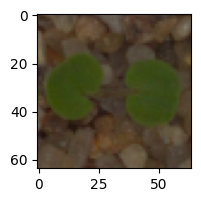

1/1 [==============================] - 0s 47ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


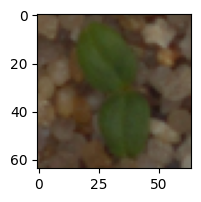

1/1 [==============================] - 0s 46ms/step
Predicted Label ['Cleavers']
True Label Cleavers


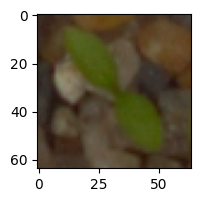

1/1 [==============================] - 0s 36ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


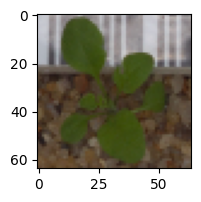

1/1 [==============================] - 0s 76ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Shepherds Purse


In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
#use model1 or model2
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[2])

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[33])

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[59])

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Actionable Insights and Business Recommendations

* Model2 suggested that data augmentation significantly improved recognition accuracy from model 1. However, at an f1-score of 0.75, neither of these models are accurate enough to be used in a real life situtation. Business recomemndations would be to continue to improve model accuracy
*   Model accuracy can first and foremost be improved by increasing the amount of data. The more training data available, the more likely for the models accuracy to increase.
*   Improving the model via improvements such as reducing the learning rate, as we have done above
*   Overall, the model is a fantastic beginning point to address the issue of identifying and categprizing plant-life, however, more work will need to be done before this model can be implemented in real life solutions.




In [ ]:
# jupyter nbconvert --to html //Daniel_Lien_Plant_Seedling_Classification.ipynb
# jupyter nbconvert --to FORMAT Daniel_Lien_Plant_Seedling_Classification.ipynb
%%shell
jupyter nbconvert Daniel_Lien_Plant_Seedling_Classification.ipynb --to html

[NbConvertApp] Converting notebook Daniel_Lien_Plant_Seedling_Classification.ipynb to html
[NbConvertApp] Writing 2661638 bytes to Daniel_Lien_Plant_Seedling_Classification.html


_____